In [ ]:
'''
This development of this code has been aided by the following resources:
https://arxiv.org/pdf/1512.09300.pdf

https://colab.research.google.com/gist/cwkx/f4b49cd3efc0e624bc22c89c90921931/spectral-norm-gan.ipynb#scrollTo=MK1Jl7nkLnPA
https://colab.research.google.com/gist/cwkx/e63ea58890a496d65467761a879c717a/dl-assignment.ipynb 
https://github.com/Yangyangii/GAN-Tutorial/blob/master/CARS/DCGAN.ipynb

'''

In [1]:
# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import random
!pip install -q torch torchvision livelossplot
from livelossplot import PlotLosses
import cv2


# hyperparameters
batch_size  = 64
n_channels  = 3
latent_size = 512
epoch = 0
total_epoch = 250
dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Plotting loss graphs
# Taken from https://colab.research.google.com/gist/cwkx/f4b49cd3efc0e624bc22c89c90921931/spectral-norm-gan.ipynb#scrollTo=MK1Jl7nkLnPA
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
liveplot = PlotLosses()

In [2]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_horses = 7
class_birds = 2
class_airplane = 0

# you may use cifar10 or stl10 datasets

dataset = "cifar10"
if dataset == "cifar10":
  print("cifar10")
  dataset_train = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])) #VAE-GAN has normalize
  dataset_test = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
]))
  dataset = torch.utils.data.ConcatDataset((dataset_train, dataset_test))
  horses = []
  wings = []
  horses_and_wings = []
  for i in dataset:
    if i[1] == class_birds or i[1] == class_airplane:
        wings.append(i)
        horses_and_wings.append(i)
    if i[1] == class_horses:
        horses.append(i)
        horses_and_wings.append(i)
  print(f"Number of winged: {len(wings):,}")
  print(f"Number of horses: {len(horses):,}")
  train_loader = torch.utils.data.DataLoader(horses_and_wings, shuffle=True, batch_size=batch_size, drop_last=True)
  train_iterator = iter(cycle(train_loader))

  print(f'> Size of dataset (training + test): {len(train_loader.dataset):,}')

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

cifar10
Files already downloaded and verified
Files already downloaded and verified
Number of winged: 12,000
Number of horses: 6,000
> Size of dataset (training + test): 18,000


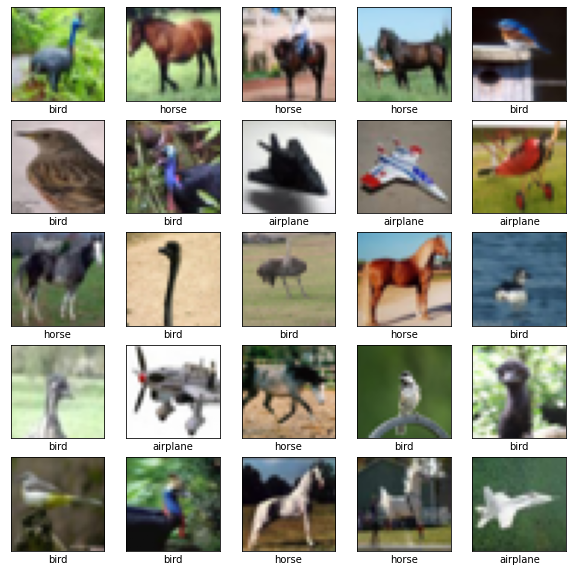

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_loader.dataset[i][1]])

**Define a simple convolutional autoencoder**

In [5]:
# simple block of convolution, batchnorm, and leakyrelu
class ConvBlock(nn.Module):
    def __init__(self, in_f, out_f, stride):
        super(ConvBlock, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=5, stride = stride, padding=2, bias = False),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)
class upConvBlock(nn.Module):
    def __init__(self, in_f, out_f, stride):
      super(upConvBlock, self).__init__()
      self.f = nn.Sequential(
          nn.ConvTranspose2d(in_f, out_f, kernel_size=5, stride=stride, padding=2, output_padding = 1, bias = False),
          nn.BatchNorm2d(out_f),
          nn.LeakyReLU(inplace=True)
      )

    def forward(self,x):
      return self.f(x)

In [6]:
class GAN_Discriminator(nn.Module):
  def __init__(self):
      super(GAN_Discriminator, self).__init__()

      self.discriminate = nn.Sequential(
          nn.Conv2d(3, 32, 5, 1, 2, bias=False),
          nn.LeakyReLU(inplace=True),
          ConvBlock(32, 128, 2),
          ConvBlock(128, 256, 2),
          ConvBlock(256, 256, 1)
      )
       
      self.lin = nn.Sequential(
        nn.Linear(256 * 8 * 8, 512, bias=False),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 1),
        nn.Sigmoid()
      )

  def feature(self, x):
    f = self.discriminate(x)
    return f.view(-1, 256 * 8 * 8)

  def forward(self, x):
      x = self.discriminate(x)
      x = x.view(-1, 256 * 8 * 8)
      x = self.lin(x)       
      return x
GD = GAN_Discriminator().to(device)
print(f'> Number of Discriminator parameters {len(torch.nn.utils.parameters_to_vector(GD.parameters()))}')
optimiser_GD = torch.optim.Adam(GD.parameters(), lr=0.0002, betas=(0.5, 0.999))

> Number of Discriminator parameters 10953825


In [7]:
# We drop the bias term because the BatchNorm2d makes it redundant
class VAE_Encoder(nn.Module):
    def __init__(self, n_channels = 3, f=64, latent_length = 100):
        super(VAE_Encoder, self).__init__()
        self.conv = nn.Sequential(
            ConvBlock(n_channels, f, 1),
            ConvBlock(f  ,f*2, 2),
            ConvBlock(f*2,f*4, 2),
        )
        self.lin = nn.Sequential(
            nn.Linear(256 * 8 * 8, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(inplace=True)
        )
        self.mu = nn.Linear(2048, latent_length, bias = False)
        self.logvar = nn.Linear(2048, latent_length, bias = False)

    def reparameterize(self, mu, logvar):
        if self.training:
          std = logvar.mul(0.5).exp_()
          eps = std.data.new(std.size()).normal_()
          return eps.mul(std).add_(mu)
        else:
          return mu

    def encode(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        lin = self.lin(x)
        mu1 = self.mu(lin)
        var1 = self.logvar(lin)
        return mu1, var1
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    

VE = VAE_Encoder().to(device)
print(f'> Number of encoder parameters {len(torch.nn.utils.parameters_to_vector(VE.parameters()))}')
optimiser_VE = torch.optim.Adam(VE.parameters(), lr=0.0002, betas=(0.5, 0.999))

> Number of encoder parameters 34997824


In [8]:
class VAE_Decoder(nn.Module):
  def forward(self, z):
    out = self.lin(z)
    out = out.view(out.size(0), 256, 8, 8)
    out = self.upConv(out)
    out = self.conv1(out)
    return out

  def __init__(self, n_channels = 3, latent_length = 100):
    super(VAE_Decoder, self).__init__()

    self.upConv = nn.Sequential(
      upConvBlock(256, 256, 2),
      upConvBlock(256  ,128, 2),
      nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2, bias=False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(inplace=True)
    )

    self.conv1 = nn.Sequential(
      nn.Conv2d(64, n_channels, kernel_size=5, stride=1, padding=2),
      nn.Tanh()
    )
    self.lin = nn.Sequential(
      nn.Linear(latent_length, 256 * 8 * 8, bias=False),
      nn.BatchNorm1d(256 * 8 * 8),
      nn.LeakyReLU(inplace=True)
    )
 
VD = VAE_Decoder().to(device)
print(f'> Number of decoder parameters {len(torch.nn.utils.parameters_to_vector(VD.parameters()))}')
optimiser_VD = torch.optim.Adam(VD.parameters(), lr=0.0002, betas=(0.5, 0.999))

> Number of decoder parameters 4339267


In [9]:
def disc_loss(x, y_real):
  y_real_loss = bce_loss(GD(x), y_real)
  y_fake_loss = bce_loss(GD(x_fake), y_fake)
  y_p_loss = bce_loss(GD(x_p), y_real)
  loss_GD = (y_real_loss + y_fake_loss + y_p_loss) / 3.0
  return loss_GD

def dec_loss(x, y_fake):
  y_real_loss = bce_loss(GD(x), y_fake)
  y_fake_loss = bce_loss(GD(x_fake), y_real)
  y_p_loss = bce_loss(GD(x_p), y_real)
  return y_p_loss


**Main training loop**

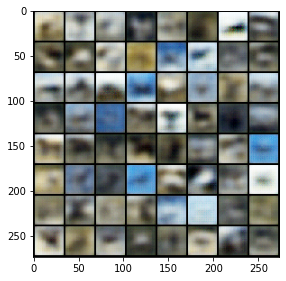

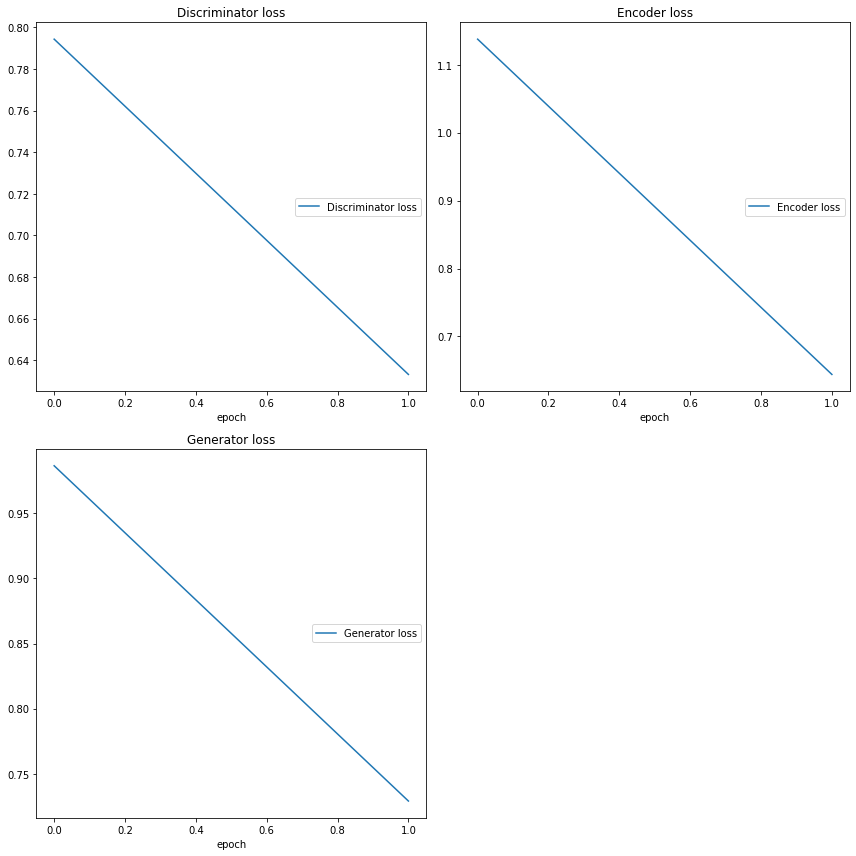

Discriminator loss
	Discriminator loss 	 (min:    0.633, max:    0.794, cur:    0.633)
Encoder loss
	Encoder loss     	 (min:    0.644, max:    1.138, cur:    0.644)
Generator loss
	Generator loss   	 (min:    0.729, max:    0.986, cur:    0.729)




In [10]:
y_real = torch.ones(batch_size, 1).to(device)
y_fake = torch.zeros(batch_size, 1).to(device)

for epoch in range(total_epoch):
  
    # arrays for metrics
    losslog_VE = np.zeros(0)
    losslog_VD = np.zeros(0)
    losslog_GD = np.zeros(0)

    for i in range(100):

        x, t = next(train_iterator)
        x, t = x.to(device, dtype=torch.float), t.to(device)
  
        if x.shape[0] == batch_size:

            # Discriminator
            z, mu, logvar = VE(x)
            x_fake = VD(z)

            latent_noise = torch.randn(batch_size, 100)
            latent_noise = latent_noise.to(device)
            x_p = VD(latent_noise)

            # Discriminator loss
            loss_GD = disc_loss(x, y_real)
            loss_GD.backward(retain_graph = True)
            optimiser_GD.step()

            # Encoder 
            x, _ = next(train_iterator)
            x = x.to(device, dtype=torch.float)
            z, mu, logvar = VE(x)
            x_fake = VD(z)

            # Encoder Loss
            prior = 1e-2 * (-0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()))
            llike = l1_loss(GD.feature(x_fake), GD.feature(x))
            recon = 5 * l1_loss(x_fake, x)    
            loss_VE = prior + recon + llike
            optimiser_VE.zero_grad()
            loss_VE.backward()
            optimiser_VE.step()


            # Decoder
            x, _ = next(train_iterator)
            x = x.to(device, dtype=torch.float)
            latent_noise = torch.randn(batch_size, 100)
            latent_noise = latent_noise.to(device)
            z, mu, logvar = VE(x)
            x_fake = VD(z)
            x_p = VD(latent_noise)

            # Decoder loss
            
            Loss_gan_fake = dec_loss(x, y_fake)
            recon = 5 * l1_loss(x_fake, x)
            llike = l1_loss(GD.feature(x), GD.feature(x))

            loss_VD = recon + llike + Loss_gan_fake
            optimiser_VD.zero_grad()
            loss_VD.backward()
            optimiser_VD.step()
            
            losslog_VE = np.append(losslog_VE, loss_VE.item())
            losslog_VD = np.append(losslog_VD, loss_VD.item())
            losslog_GD = np.append(losslog_GD, loss_GD.item())

            print("Epoch: " + str(epoch)  
            +" out of " + str(total_epoch) + " and Step: " + str(i) + "/100")

    # plot some examples
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(x_fake).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    # Taken from https://colab.research.google.com/gist/cwkx/f4b49cd3efc0e624bc22c89c90921931/spectral-norm-gan.ipynb#scrollTo=kb5909Y8D_zx
    liveplot.update({
        'Encoder loss': losslog_VE.mean(),
        'Generator loss': losslog_VD.mean(),
        'Discriminator loss': losslog_GD.mean()
    })
    liveplot.draw()

    print("\n")


evaluated


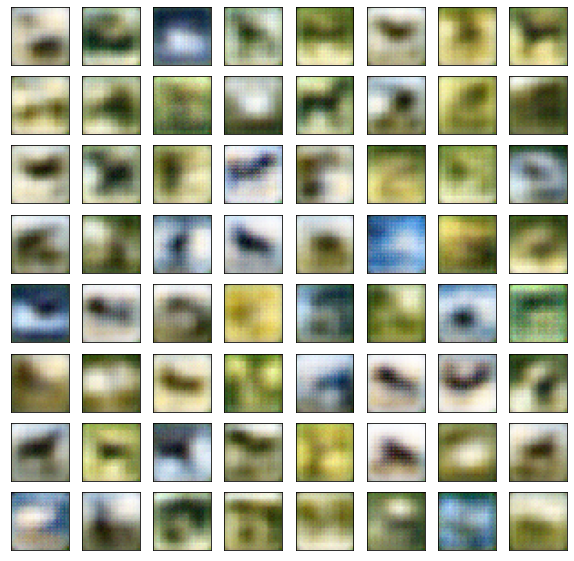

In [11]:
VE.eval()
VD.eval()
GD.eval()
print("evaluated")
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])

    # Choose one random horse and plane
    horse = random.choice(horses)[0].to(device, dtype=torch.float)
    wing = random.choice(wings)[0].to(device, dtype=torch.float)
    horse_encoded = VE(horse.unsqueeze(0))[0]
    wing_encoded = VE(wing.unsqueeze(0))[0]
    pegasus = VD(horse_encoded * 0.6 + wing_encoded * 0.4).squeeze(0)
    pegasus = pegasus.cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0).numpy()
    pegasus = cv2.normalize(pegasus, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    plt.grid(False)
    plt.imshow(pegasus, cmap=plt.cm.binary,)

plt.show()